In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from DataManagement import loadFiles, impute, calcSofa


%matplotlib inline

### Data cleaning and merging

In [2]:
caseAbstractions, rawData = loadFiles()

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:370: UserWarning: Encountered %tC format. Leaving in Stata Internal Format.
  warnings.warn("Encountered %tC format. Leaving in Stata " "Internal Format.")


In [3]:
for col in rawData.columns:
    if "Missing" in col:
        print(f"column: {col}, total missing: {rawData[col].sum()}, % missing: {rawData[col].sum()/len(rawData)*100:.1f}")

column: totalMissing, total missing: 1975, % missing: 461.4
column: sbpMissing, total missing: 0, % missing: 0.0
column: dbpMissing, total missing: 0, % missing: 0.0
column: hrMissing, total missing: 0, % missing: 0.0
column: rrMissing, total missing: 0, % missing: 0.0
column: tempMissing, total missing: 1, % missing: 0.2
column: crpMissing, total missing: 136, % missing: 31.8
column: dDimerMissing, total missing: 145, % missing: 33.9
column: ferritinMissing, total missing: 133, % missing: 31.1
column: plateletsMissing, total missing: 32, % missing: 7.5
column: lymphMissing, total missing: 34, % missing: 7.9
column: creatinineMissing, total missing: 33, % missing: 7.7
column: tbiliMissing, total missing: 81, % missing: 18.9
column: hsTropMissing, total missing: 270, % missing: 63.1
column: il6Missing, total missing: 358, % missing: 83.6
column: hgbMissing, total missing: 32, % missing: 7.5
column: lacMissing, total missing: 149, % missing: 34.8
column: ldhMissing, total missing: 155, %

### Imputation

In [4]:
cleanedData, imputedData = impute(rawData)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


In [5]:
withMissing = {}
for key in imputedData.models.keys():
    withMissing[key] = imputedData.models[key].fit().rsquared
withMissing

{'temp': 0.21055508609449558,
 'platelets': 0.24344548096630925,
 'hgb': 0.47232719766640163,
 'creatinine': 0.29678098995483093,
 'lymph': 0.33118709647738387,
 'albumin': 0.3916458879239705,
 'tbili': 0.25263995758521907,
 'ferritin': 0.28650846188806567,
 'crp': 0.4236304628857771,
 'dDimer': 0.25609348476591576,
 'lac': 0.41758379832213777,
 'ldh': 0.4812129458834218,
 'hsTrop': 0.6607732745370609,
 'il6': 0.4151791653414122}

### Post imputation data management

In [6]:
cleanedData = calcSofa(cleanedData)
cleanedData['comorbidityCount'] = cleanedData[['hypertension', 'diabetes','asthma', 'copd', 'chronic_lung', 'osa', 'immunocompromised']].sum(axis='columns')

### Defining models

In [7]:
factorsWithPriors = ['age', 'female', 'lymph', 'crp', 'o2Sat', 'ldh']
factorsWithoutPriors =  ['dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac',  'albumin', 'creatinine', 'platelets', 'tbili', 'hr', 'rr', 'temp', 'map', 'comorbidityCount']
missCols = [col for col in cleanedData.columns if "Missing" in col]
outcomes = ['icu', 'primaryOutcome', 'lastTime']

allCols = factorsWithPriors.copy()
allCols.extend(factorsWithoutPriors)
allCols.extend(missCols)
allPredictors = allCols.copy()
allCols.extend(outcomes)


modelData = cleanedData[allCols]

In [8]:
modelData.icu.value_counts()

False    370
True      58
Name: icu, dtype: int64

In [9]:
modelData.primaryOutcome.value_counts()

False    337
True      91
Name: primaryOutcome, dtype: int64

In [10]:
import pymc3 as pm
from theano import shared, tensor as tt

In [11]:
def getBetaNameForLab(lab):
    return 'beta' + lab.capitalize()

In [12]:
def setupAndRunLogisticModel(outcome):
    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=0, sd=10)
        betaLinearAge = pm.Normal('betaAge', mu=0.05, sd=0.05)

        betaLymph = pm.Normal('betaLymph', mu=-1.4, sd=0.5)
        betaFemale = pm.Normal('betaFemale', mu=-0.5, sd=0.15)
        betaLdh = pm.Normal('betaLdh', mu=0.004, sd=0.002)
        betaCrp = pm.Normal('betaCrp', mu=0.02, sd=0.01)
        betaSat = pm.Normal('betaSat', mu=-0.1, sd=0.05)

        age = pm.Data('age', modelData['age'].values)
        crp = pm.Data('crp', modelData['crp'].values)
        lymph = pm.Data('lymph', modelData['lymph'].values)
        ldh = pm.Data('ldh', modelData['ldh'].values)
        o2Sat = pm.Data('o2Sat', modelData['o2Sat'].values)
        female = pm.Data('female', modelData['female'].values)

        # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
        for factor in factorsWithoutPriors:
            name = getBetaNameForLab(factor)
            setattr(model, name, pm.Normal(name, mu=0, sd=0.05))
            setattr(model, factor, pm.Data(factor, modelData[factor]))


        # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
        mu = alpha + betaLinearAge * age  + betaLymph * lymph + betaFemale * female + crp *betaCrp +  o2Sat * betaSat  + ldh * betaLdh 


        for factor  in factorsWithoutPriors:   
            mu += getattr(model, getBetaNameForLab(factor)) * getattr(model, factor)

        θ = pm.Deterministic('θ', pm.math.sigmoid(mu))

        y_1 = pm.Bernoulli('y_1', p=θ, observed=outcome)

        trace = pm.sample(1000, tune=1500, cores=4)
    return model, trace

In [13]:
# primary outcome model
# crude priors from:  Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study. The Lancet, 1–9. http://doi.org/10.1016/S0140-6736(20)30566-3
logitPrimaryOutcome, tracePrimaryOutcome = setupAndRunLogisticModel(modelData.primaryOutcome)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaComorbiditycount, betaMap, betaTemp, betaRr, betaHr, betaTbili, betaPlatelets, betaCreatinine, betaAlbumin, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaSat, betaCrp, betaLdh, betaFemale, betaLymph, betaAge, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [01:54<00:00, 87.26draws/s]
The acceptance probability does not match the target. It is 0.8797638709539003, but should be close to 0.8. Try to increase the number of tuning steps.


In [14]:
# main ICU model
logitICUWIthPriors, trace_ICU = setupAndRunLogisticModel(modelData.icu)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaComorbiditycount, betaMap, betaTemp, betaRr, betaHr, betaTbili, betaPlatelets, betaCreatinine, betaAlbumin, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaSat, betaCrp, betaLdh, betaFemale, betaLymph, betaAge, alpha]
Sampling 4 chains, 1 divergences: 100%|██████████| 10000/10000 [01:51<00:00, 89.94draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8812485111897203, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
# weibull primary outcome

# based on parameterization 1 here...https://docs.pymc.io/notebooks/weibull_aft.html
# for non-censored observations, outcomes are defined
modelData.loc[:,'time'] = np.log(modelData.lastTime)
modelData.loc[:,'timeStandardized'] = (modelData.time - modelData.time.mean()) / modelData.time.std()
modelData.loc[:,'censored'] = ~modelData.primaryOutcome

censored = np.array(modelData.censored)
nonCensored = np.array(~modelData.censored)

# convert to log-transformed values
#time = np.log(modelData.lastTime.values)
time = modelData.lastTime.values

def weibull_lccdf(t, alpha, beta):
    ''' Log complementary cdf of Weibull distribution. '''
    return -(t / beta)**alpha

def weibull_surv(l, p, t):
    return np.exp(-1*(l*t)**p)

with pm.Model() as weibull_primary_outcome_all_covariates:
    alpha_sd = 10.0
    intercept = pm.Normal('intercept', mu=0, sd=10)
    betaLinearAge = pm.Normal('betaAge', mu=-0.05, sd=0.05)
    betaLymph = pm.Normal('betaLymph', mu=1.4, sd=0.5)
    betaFemale = pm.Normal('betaFemale', mu=0.5, sd=0.15)
    betaLdh = pm.Normal('betaLdh', mu=-0.004, sd=0.002)
    betaCrp = pm.Normal('betaCrp', mu=-0.02, sd=0.01)
    betaSat = pm.Normal('betaSat', mu=0.1, sd=0.05)

    age = pm.Data('age', modelData['age'].values)
    crp = pm.Data('crp', modelData['crp'].values)
    lymph = pm.Data('lymph', modelData['lymph'].values)
    ldh = pm.Data('ldh', modelData['ldh'].values)
    o2Sat = pm.Data('o2Sat', modelData['o2Sat'].values)
    female = pm.Data('female', modelData['female'].values)


    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for factor in factorsWithoutPriors:
        name = getBetaNameForLab(factor)
        setattr(weibull_primary_outcome_all_covariates, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(weibull_primary_outcome_all_covariates, factor, pm.Data(factor, modelData[factor]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = intercept + betaLinearAge * age  + betaLymph * lymph + betaFemale * female + crp *betaCrp +  o2Sat * betaSat  + ldh * betaLdh 


    
    for factor  in factorsWithoutPriors:   
        mu += getattr(weibull_primary_outcome_all_covariates, getBetaNameForLab(factor)) * getattr(weibull_primary_outcome_all_covariates, factor)

    
    alpha_raw = pm.Normal('a0', mu=0, sigma=1)
    alpha = pm.Deterministic('alpha', tt.exp(alpha_sd * alpha_raw))
    
    y_obs = pm.Weibull('y_obs', alpha=alpha, beta=tt.exp(mu[~censored]/alpha), observed=time[~censored])
    y_cens = pm.Potential('y_cens', weibull_lccdf(time[censored], alpha, tt.exp(mu[censored]/alpha)))

    outcome1 = pm.Deterministic('outcome1', weibull_surv(1/mu, alpha, 1))
    outcome3 = pm.Deterministic('outcome3', weibull_surv(1/mu, alpha, 3))
    outcome7 = pm.Deterministic('outcome7',  weibull_surv(1/mu, alpha, 7))
    outcome14 = pm.Deterministic('outcome14', weibull_surv(1/mu, alpha, 14))
    outcome28 = pm.Deterministic('outcome28', weibull_surv(1/mu, alpha, 28))

    
    traceTimeToEventSimpleWeibullReversedPriors = pm.sample(1000, tune=1000, chains=4, cores=4, init='adapt_diag')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

In [16]:
# # icu model that includes missing variable flags
# def getBetaNameForLab(lab):
#     return 'beta' + lab.capitalize()

# labs = ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp']
# missCols = [col for col in modelData.columns if "Missing" in col]

# with pm.Model() as logitICUWIthPriors:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
#     betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
#     betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
#     betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
#     betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)
#     #betaTotalMissing = pm.Normal('betaTotalMissing', mu=0, sd=10)
#     #totalMissing = pm.Data('totalMissing', modelData.totalMissing)

#     # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
#     for lab in labsVitals:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
#     # explore individual missing variables
#     for lab in missCols:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
        
#     # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
#     mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
#         betaFemale * modelData.female 
    
#     for lab  in labsVitals:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
#     for lab  in missCols:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)


#     θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
#     y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

#     trace_ICU_Missing = pm.sample(1000, tune=3000, cores=4)

In [17]:
# # icu model on the dataset with minimal missingess
# def getBetaNameForLab(lab):
#     return 'beta' + lab.capitalize()

# with pm.Model() as logitICUWIthPriors:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
#     betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
#     betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
#     betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
#     betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


#     # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
#     for lab in labsVitals:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, noMissing[lab]))
        
    
#     # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
#     mu = alpha + betaAge * noMissing.age + betaSofa * noMissing.sofa + betaLymph * noMissing.lymph + \
#         betaFemale * noMissing.female 
    
#     for lab  in labsVitals:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
#     θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
#     y_1 = pm.Bernoulli('y_1', p=θ, observed=noMissing.icu)

#     trace_ICU_NoMissing = pm.sample(1000, tune=3000, cores=4)

### Reporting

In [18]:
def assessOverallPerformance(model, trace, name, outcomeForComparison, varName='y_1'):
    ppcs = pm.sample_posterior_predictive(trace=trace, model=model, samples=1000, var_names=[varName])
    
    posteriorName = 'posterior' + name

    modelData[posteriorName] = np.nanmean(ppcs[varName], axis=0)
    modelData[posteriorName].fillna(modelData[posteriorName].mean(), inplace=True)

    preds = np.rint(modelData[posteriorName]).astype('int')

    print(f'Accuracy: {accuracy_score(outcomeForComparison, preds):.3f}')
    print(f'f1 score: {f1_score(outcomeForComparison, preds):.3f}')
    roc = roc_auc_score(outcomeForComparison, modelData[posteriorName])
    print(f'ROC: {roc:.3f}')
    return ppcs, roc

In [19]:
def assessParameterInfluence(model, trace, varName='y_1'):   
    labsToKeep = []
    marginalInputsForLab = {}
    marginalOutputsForLab = {}

    ninetyMinusTenForLab = {}

    labs=['totalMissing']
    
    parametersToAssess = factorsWithoutPriors
    parametersToAssess.extend(['lymph', 'crp', 'ldh', 'o2Sat'])


    for var in factorsWithoutPriors:
        with model:
            valuesToCheck = {'min': modelData[var].min(), '1st':modelData[var].quantile(0.01),
                             '10th':modelData[var].quantile(0.10), '25th':modelData[var].quantile(0.25), 
                             '50th':modelData[var].quantile(0.50), '75th':modelData[var].quantile(0.75), 
                             '90th':modelData[var].quantile(0.90), '99th':modelData[var].quantile(0.99),
                             'max':modelData[var].max()}
            ppcsAtValue = dict.fromkeys(valuesToCheck.keys())

            for key, value in valuesToCheck.items():
                pm.model.set_data({var: np.repeat(value, len(modelData))})
                pccsForLabValue = pm.sample_posterior_predictive(trace, samples=1000, progressbar=False, var_names=[varName])
                ppcsAtValue[key] = pccsForLabValue[varName].mean(axis=0).mean()
                marginalOutputsForLab[var] = ppcsAtValue
                marginalInputsForLab[var] = valuesToCheck
            ninetyMinusTen = ppcsAtValue['90th'] - ppcsAtValue['10th']
            ninetyMinusTenForLab[var] = ninetyMinusTen

            if np.abs(ninetyMinusTen) > 0.05:
                labsToKeep.append(var)
    return (labsToKeep, marginalOutputsForLab, marginalInputsForLab, ninetyMinusTenForLab)

In [20]:
def getDataObject(model, trace, ppc):
    with model:

        data = az.from_pymc3(
            trace=trace,
            prior=pm.sample_prior_predictive(),
            posterior_predictive=ppc,
            model=model
        )
    return data


### Assess primary outcome

In [21]:
primaryPPCs, primaryROC = assessOverallPerformance(logitPrimaryOutcome, tracePrimaryOutcome, "PrimaryOutcome", modelData.primaryOutcome)
primaryToKeep, primaryMarignalOutputs, primaryMarginalInputs, primaryNinetyMinusTen = assessParameterInfluence(logitPrimaryOutcome, tracePrimaryOutcome)
primaryData = getDataObject(logitPrimaryOutcome, tracePrimaryOutcome, primaryPPCs )

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 574.04it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_gu

Accuracy: 0.850
f1 score: 0.562
ROC: 0.864


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [22]:
az.summary(tracePrimaryOutcome).head(22)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,5.069,4.968,-4.603,13.991,0.094,0.074,2768.0,2262.0,2771.0,2717.0,1.0
betaAge,0.028,0.010,0.010,0.047,0.000,0.000,4909.0,4586.0,4899.0,3038.0,1.0
betaLymph,-0.027,0.018,-0.060,0.009,0.000,0.000,4689.0,4102.0,4650.0,3038.0,1.0
betaFemale,-0.515,0.134,-0.776,-0.273,0.002,0.001,6269.0,5989.0,6290.0,3108.0,1.0
betaLdh,0.002,0.001,0.000,0.003,0.000,0.000,5098.0,4363.0,5094.0,3268.0,1.0
betaCrp,0.024,0.009,0.007,0.041,0.000,0.000,6707.0,5313.0,6714.0,3048.0,1.0
betaSat,-0.103,0.027,-0.156,-0.054,0.000,0.000,4091.0,3787.0,3988.0,2662.0,1.0
betaDdimer,-0.005,0.024,-0.049,0.041,0.000,0.000,5622.0,1883.0,5640.0,3132.0,1.0
betaFerritin,0.000,0.000,-0.000,0.000,0.000,0.000,5584.0,2702.0,5623.0,3615.0,1.0
betaHstrop,0.011,0.004,0.004,0.019,0.000,0.000,4947.0,4490.0,4967.0,3124.0,1.0


In [23]:
primaryNinetyMinusTen

{'dDimer': -0.0020233644859813105,
 'ferritin': 0.007759345794392525,
 'hsTrop': 0.06299299065420566,
 'hgb': -0.012539719626168289,
 'lac': 0.002995327102803702,
 'albumin': 0.0012009345794391502,
 'creatinine': -0.0036658878504672865,
 'platelets': -0.08011214953271029,
 'tbili': 0.00045327102803738306,
 'hr': 0.038588785046729024,
 'rr': 0.11487149532710283,
 'temp': -0.00097663551401872,
 'map': -0.012469626168224224,
 'comorbidityCount': 0.010247663551401942,
 'lymph': -0.0574088785046728,
 'crp': 0.044927570093457825,
 'ldh': 0.05941355140186921,
 'o2Sat': -0.05233411214953276}

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c36079fd0>,
      dtype=object)

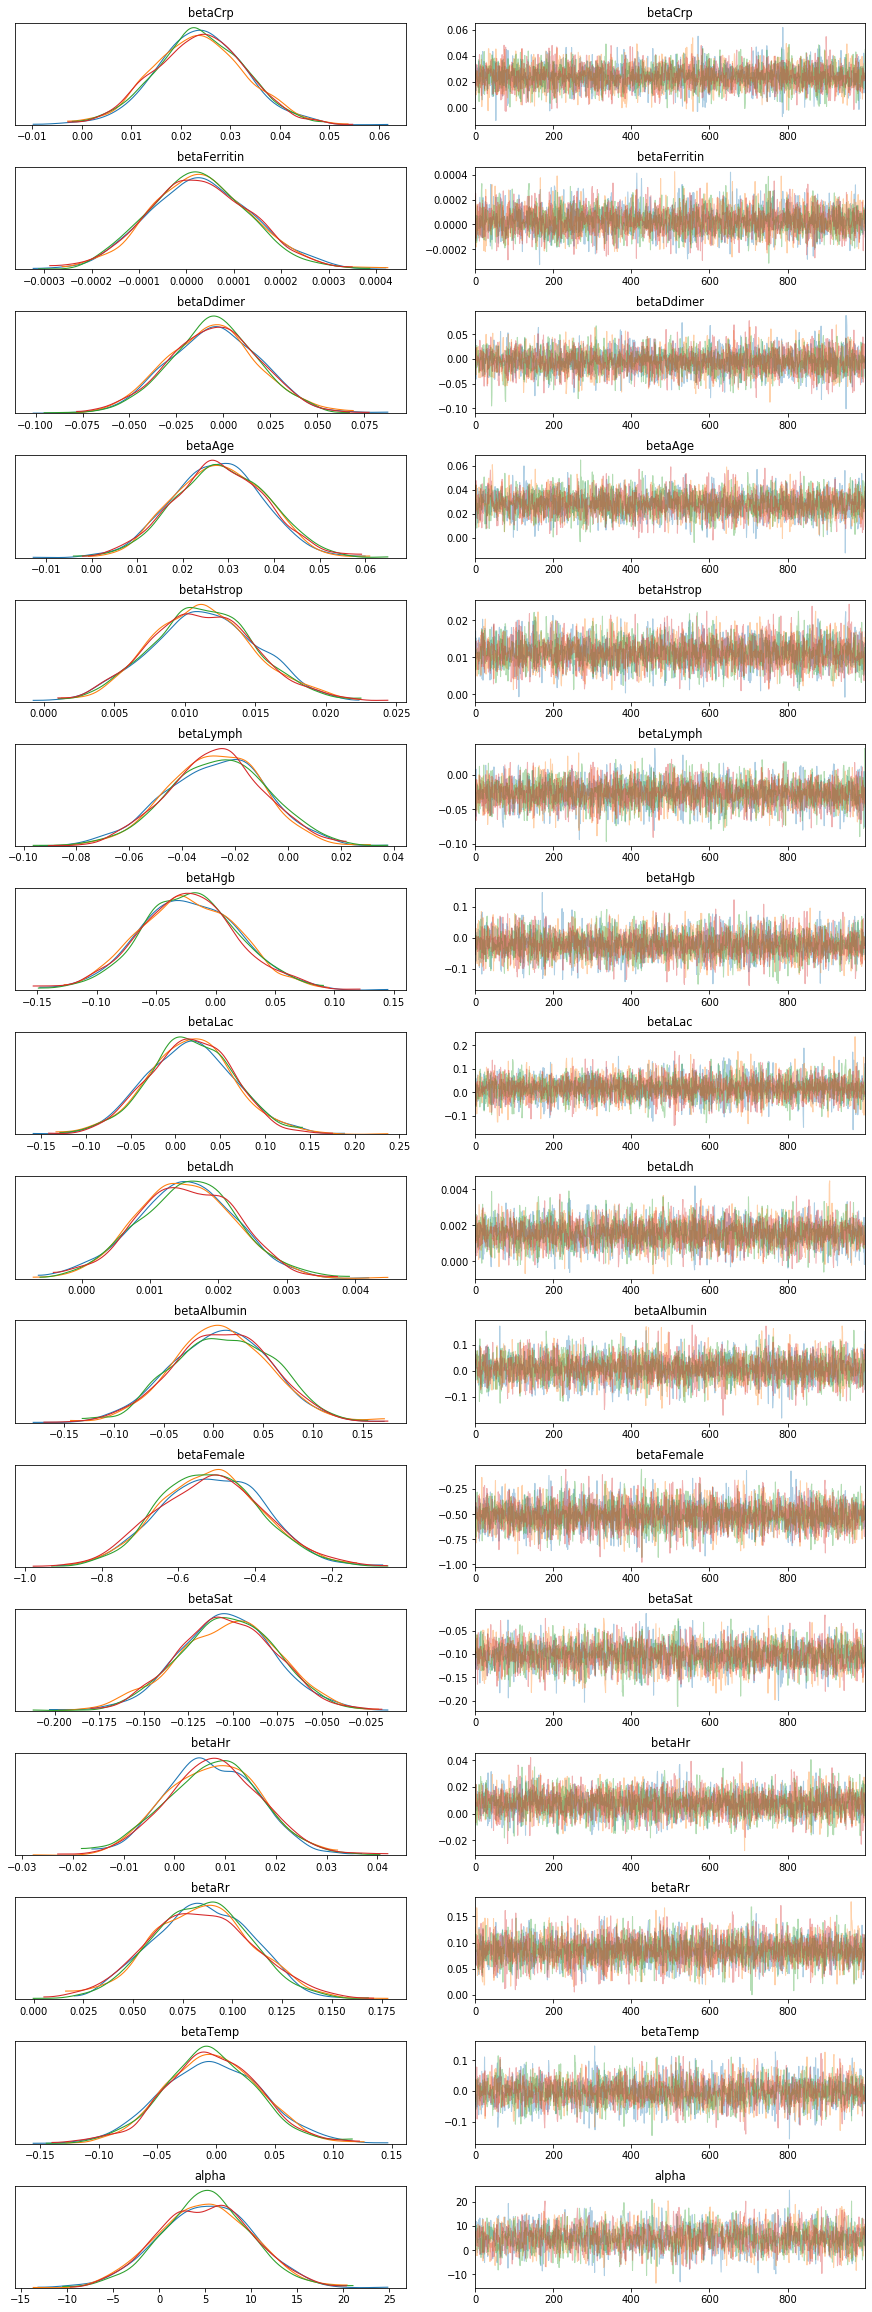

In [25]:
az.plot_trace(tracePrimaryOutcome, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                    'betaFemale', 'betaSat', 'betaHr', 'betaRr', 'betaTemp', 'alpha'])

### ICU Model

In [26]:
icuPPCs, icuROC = assessOverallPerformance(logitICUWIthPriors, trace_ICU, "ICU", modelData.icu)
icuToKeep, icuMarignalOutputs, icuMarginalInputs, icuNinetyMinusTen = assessParameterInfluence(logitICUWIthPriors, trace_ICU)
icuData = getDataObject(logitICUWIthPriors, trace_ICU, icuPPCs )

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 567.45it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_gu

Accuracy: 0.904
f1 score: 0.518
ROC: 0.853


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [27]:
az.summary(trace_ICU).head(16)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,7.051,5.115,-2.360,16.690,0.097,0.070,2780.0,2674.0,2775.0,2748.0,1.0
betaAge,0.000,0.012,-0.022,0.023,0.000,0.000,6088.0,2086.0,6084.0,3236.0,1.0
betaLymph,-0.013,0.021,-0.053,0.027,0.000,0.000,5356.0,2415.0,5533.0,2785.0,1.0
betaFemale,-0.457,0.141,-0.713,-0.194,0.002,0.001,5727.0,4876.0,5718.0,2396.0,1.0
betaLdh,0.003,0.001,0.002,0.005,0.000,0.000,5967.0,5710.0,5926.0,3216.0,1.0
betaCrp,0.023,0.009,0.005,0.040,0.000,0.000,6305.0,5590.0,6331.0,2401.0,1.0
betaSat,-0.106,0.027,-0.156,-0.057,0.000,0.000,4226.0,4120.0,4206.0,3193.0,1.0
betaDdimer,0.011,0.025,-0.036,0.061,0.000,0.000,6407.0,2091.0,6410.0,2836.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,5634.0,2204.0,5608.0,2796.0,1.0
betaHstrop,0.001,0.005,-0.007,0.010,0.000,0.000,5375.0,2134.0,5622.0,2657.0,1.0


In [28]:
icuNinetyMinusTen

{'dDimer': 0.0020327102803738284,
 'ferritin': -0.011317757009345786,
 'hsTrop': 0.004025700934579435,
 'hgb': 0.008205607476635568,
 'lac': 0.003214953271028026,
 'albumin': -0.0014462616822429886,
 'creatinine': -0.0016705607476635298,
 'platelets': -0.017345794392523373,
 'tbili': -0.00040186915887849284,
 'hr': -0.01682710280373828,
 'rr': 0.06857943925233645,
 'temp': -0.005399532710280375,
 'map': -0.01158644859813085,
 'comorbidityCount': 0.004869158878504698,
 'lymph': -0.02516822429906529,
 'crp': 0.0396705607476634,
 'ldh': 0.1549579439252336,
 'o2Sat': -0.06403504672897198}

### Weibull Survival Model

In [29]:
pm.summary(traceTimeToEventSimpleWeibullReversedPriors).head(23)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils -

arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.st

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,-1.025,4.319,-9.209,6.840,0.088,0.069,2426.0,1944.0,2429.0,2478.0,1.0
betaAge,-0.021,0.008,-0.035,-0.006,0.000,0.000,4120.0,4073.0,4106.0,2741.0,1.0
betaLymph,0.028,0.016,-0.000,0.060,0.000,0.000,4137.0,3357.0,4221.0,3040.0,1.0
betaFemale,0.515,0.131,0.266,0.748,0.002,0.001,4756.0,4639.0,4774.0,3332.0,1.0
betaLdh,-0.001,0.001,-0.002,-0.000,0.000,0.000,3327.0,3327.0,3335.0,2743.0,1.0
betaCrp,-0.022,0.008,-0.037,-0.007,0.000,0.000,3857.0,3725.0,3831.0,3138.0,1.0
betaSat,0.050,0.015,0.021,0.078,0.000,0.000,2806.0,2778.0,2804.0,2593.0,1.0
betaDdimer,0.011,0.017,-0.019,0.046,0.000,0.000,3771.0,2427.0,3870.0,2465.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,3458.0,3280.0,3529.0,2814.0,1.0
betaHstrop,-0.007,0.002,-0.011,-0.003,0.000,0.000,3223.0,3223.0,3237.0,2865.0,1.0


In [30]:
survivalPPCs, survivalROC = assessOverallPerformance(model=weibull_primary_outcome_all_covariates, 
                                                     trace=traceTimeToEventSimpleWeibullReversedPriors, 
                                                     name="Survival", 
                                                     outcomeForComparison=(1-modelData.primaryOutcome),
                                                     varName='outcome28')
survivalToKeep, survivalMarignalOutputs, survivalMarginalInputs, survivalNinetyMinusTen = assessParameterInfluence(weibull_primary_outcome_all_covariates, traceTimeToEventSimpleWeibullReversedPriors, varName='outcome28')
survivalData = getDataObject(weibull_primary_outcome_all_covariates, traceTimeToEventSimpleWeibullReversedPriors, survivalPPCs )

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 629.45it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy

Accuracy: 0.213
f1 score: 0.000
ROC: 0.852


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


### Calibration 

In [31]:
outputDF = pd.DataFrame({'predicted icu' : modelData.posteriorICU, 'icu' : modelData.icu,
                         'predicted primary outcome' : modelData.posteriorPrimaryOutcome,
                         'primary outcome' : modelData.primaryOutcome})
outputDF['icuDecile'] = pd.qcut(outputDF['predicted icu'], 10)
outputDF['primaryOutcomeDecile'] = pd.qcut(outputDF['predicted primary outcome'], 10)

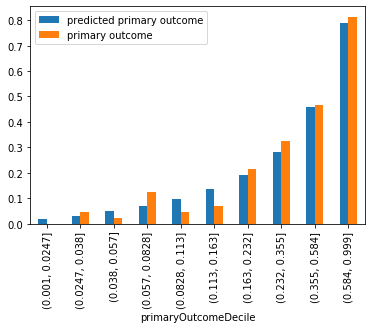

In [32]:
# primary outcome
from datetime import date
outputDF[['predicted primary outcome', 'primary outcome', 'primaryOutcomeDecile']].groupby('primaryOutcomeDecile').mean().plot.bar()
plt.savefig(f'static/primaryOutcomeCalibration{str(date.today())}.jpg')


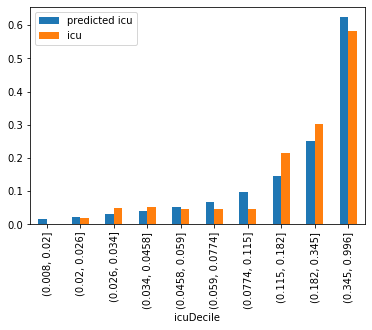

In [33]:
# icu
outputDF[['predicted icu', 'icu', 'icuDecile']].groupby('icuDecile').mean().plot.bar()
plt.savefig(f'static/icuCalibration{str(date.today())}.jpg')

In [47]:
def saveModelOutcomes(trace, ninetyMinusTen, name):
    modelCoefficients = az.summary(trace, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaHr', 'betaRr', 'betaTemp', 'betaSat','alpha', 
                                      'betaComorbiditycount', 'betaMap', 'betaSat', 'betaPlatelets',
                                      'betaTbili', 'betaCreatinine'])[['mean', 'sd']]
    modelCoefficients.rename(columns={'mean': 'beta', 'sd':'sdBeta'}, inplace=True)
    for key, value in ninetyMinusTen.items():
        modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'priority'] = np.abs(value)
        modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'p50'] = modelData[key].quantile(0.50)
    
    for i, row in modelCoefficients.iterrows():
        if row.name[0:4] == 'beta':
            modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name[4:].lower()
        else:
            modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name
    modelCoefficients.to_stata(f'{name}Coeffs-{str(date.today())}.dta')
    return modelCoefficients


In [48]:
icuCoeffs = saveModelOutcomes(trace_ICU, icuNinetyMinusTen, "ICU")
primaryCoeffs = saveModelOutcomes(tracePrimaryOutcome, primaryNinetyMinusTen, "PrimaryOutcome")
survivalCoeffs = saveModelOutcomes(traceTimeToEventSimpleWeibullReversedPriors, survivalNinetyMinusTen, "Survival")

modelData.to_stata(f'modelData-{str(date.today())}.dta')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [41]:
import json


modelPerformance = {}
modelPerformance['icuROC'] = icuROC
modelPerformance['primaryROC'] = primaryROC
modelPerformance['survivalROC'] = survivalROC


with open(f'modelPerformance-{str(date.today())}.json', 'w') as outfile:
    json.dump(modelPerformance, outfile)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y=modelData["posteriorICU"], name="ICU Risk Distribution"), )
fig.add_trace(go.Box(y=modelData["posteriorPrimaryOutcome"], name="Primary Outcome Risk Distribution"), )

fig.add_trace(go.Scatter(y=[0.5]))
fig.show()

In [ ]:
# workflow...

# download data
# clean datat (in this worksheet)
# impute missing values
# run baseline model
# prioritize coefficients
# export coefficients, data file and model performance
# update the priority in teh UI — done
# 

In [ ]:
# there is a fairly reasonable agreement between our baseline bayesian model and a default-tuned elastic net
# that seesm liek a decent argument that our pessimism was calibrated reasonably...

In [ ]:
# from glmnet import LogitNet

# m = LogitNet()
# m = m.fit(modelData.loc[:,!modelData.columns.in(['icu', 'posteriorProbabilities']), modelData.icu)

In [ ]:
#modelData

In [ ]:
#m.coef_